## Two-layer neural network
In this notebook a two-layer neural network is implemented from scratch following the methodology of the course http://cs231n.github.io/.

The structure of the network is the following:

    INPUT -> FC -> ReLU -> FC -> OUTPUT -> SOFTMAX LOSS.

*The goal of this notebook is to store some of my thoughts obtained while going through the course.* Especially notes about backpropagation in case of composition of functions, since I found it difficult to fully understand w.r.t. (with respect to) which variable the derivatives are computed at each stage. 

Important concept presented here is distinguishing between the layer's input and output, which makes the understanding of backpropagation easier.  

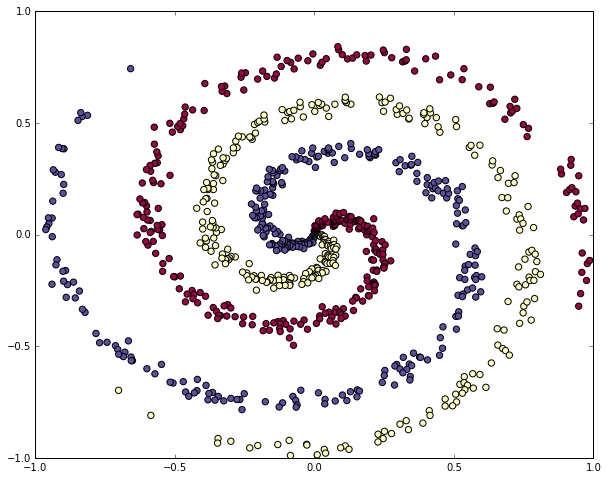

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data generation obtained from http://cs231n.github.io/neural-networks-case-study/
def generate_data(N, K):
    D = 2   # Dimensionality
    X = np.zeros((N * K, D))            # Data matrix (each row = single example)
    y = np.zeros(N * K, dtype='uint8')  # Class labels
    for j in xrange(K):
      ix = range(N * j, N * (j + 1))
      r = np.linspace(0.0, 1, N)                                         # radius
      t = np.linspace(j * 8, (j + 1) * 8, N) + np.random.randn(N) * 0.2  # theta
      X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
      y[ix] = j

    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)  # Visualize
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Example:
_=generate_data(300, 3)  # Prevent the output.

The initial variance is scaled by a factor of $\sqrt[]{\frac{2}{N}}$, where $N$ is the number of inputs to each neuron in the layer (as per http://cs231n.github.io/neural-networks-2/), in order to provide the same initial output variance at each neuron. 

In [2]:
# Initialization
def initialize(num_inputs, num_hidden):
    # +1 is added to account for the bias trick.
    W1 = np.random.randn(num_inputs + 1, num_hidden) * np.sqrt(2.0 / num_inputs + 1)
    W2 = np.random.randn(num_hidden + 1, num_classes) * np.sqrt(2.0 / (num_hidden + 1))
    return W1, W2

We use the notation $h_{i,1}$, $h_{i,2}$ to specify the output of $i-$th layer before and after a nonlinearity, respectively. For example, if the $i-$th hidden layer contains a sigmoid activation function, then $$h_{i,1}=h_{i-1,2}W_i$$ and $$h_{i,2}=\sigma({h_{i,1}}).$$ Additionally, the bias trick could be applied to the output with nonlinearity in order to implicitly account for the bias in the weights.

In [3]:
# Forward propagate
def forw_prop(X, W1, W2):
    # Hidden layer.
    h11 = X.dot(W1)
    h12 = np.maximum(0, h11) # ReLU nonlinearity
    # Bias trick.
    h12 = np.c_[h12, np.ones(h12.shape[0])]
    # Final layer.
    f = h12.dot(W2)
    # Softmax transformation.
    probs = np.exp(f)
    prob_sums = probs.sum(axis=1, keepdims=True)
    probs /= prob_sums
    return probs, h11, h12

The loss function is defined as the mean of sample losses $$ L_i = -f_i[y_i] + \log\Sigma_j\, e^{f_i[j]},\; \text{where }\; f_i=x_i^TW.$$ The final loss is then: $$L = \frac{1}{N} \Sigma_i^N\, L_i + \frac{\lambda}{2}(||W_1||_2^2 + ||W_2||_2^2)$$

In [4]:
# Compute the softmax loss http://cs231n.github.io/linear-classify/#softmax
def calc_loss(probs, y, W1, W2, reg):
    data_loss = -np.mean(np.log(probs[range(y.shape[0]), y]))
    reg_loss = reg * 0.5 * (np.sum(W1 * W1) + np.sum(W2 * W2))
    return data_loss + reg_loss

During forward prop, we compose multiple functions to get the final output. Those functions could be simple dot products in case of weights, or complicated nonlinear functions within neurons. An important question when doing backpropagation then is w.r.t. what to differentiate when applying the chain rule? 

For example, assume the final output is a composition of $f_1, f_2,$ and $f_3$, i.e. $f(X) = f_3(f_2(f_1(X)))$. 

We could apply the chain rule directly:
$$\frac{\partial{f}}{\partial{X}} = \frac{\partial{f_3}}{\partial{f_2}}\frac{\partial{f_2}}{\partial{f_1}}\frac{\partial{f_1}}{\partial{X}},$$
or, for example, define $g = f_3 \circ f_2$ to get:
$$\frac{\partial{f}}{\partial{X}} = \frac{\partial{g}}{\partial{f_1}} \frac{\partial{f_1}}{\partial{X}}.$$

The common approach is combine the nonlinear function(s) at the hidden layers, differentiate w.r.t. the output of the hidden layer, and back propagate through the nonlinearity to get the differential w.r.t. the input of the layer.

In [5]:
# Backpropagate
def back_prop(probs, X, y, h11, h12, W1, W2, reg):
    # Partial derivatives at the final layer.
    dL_df = probs
    dL_df[range(y.shape[0]), y] -= 1
    dL_df /= num_train
    # Propagate back to the weights, along with the regularization term.
    dL_dW2 = h12.T.dot(dL_df) + reg * W2
    # At the output of the hidden layer.
    dL_dh12 = dL_df.dot(W2.T)
    # Propagate back through nonlinearities to the input of the layer.
    dL_dh11 = dL_dh12[:,:-1] # Account for bias trick.
    dL_dh11[h11 < 0] = 0     # ReLU
    dL_dW1 = X.T.dot(dL_dh11) + reg * W1
    return dL_dW1, dL_dW2

def accuracy(X, y, W1, W2):
    h = np.maximum(0, X.dot(W1))
    h = np.c_[h, np.ones(h.shape[0])]
    f = h.dot(W2)
    return np.mean(np.argmax(f, axis=1) == y)

### Putting it all together
Now that all the neccessary functions are defined, we can prepare the data and train the network.

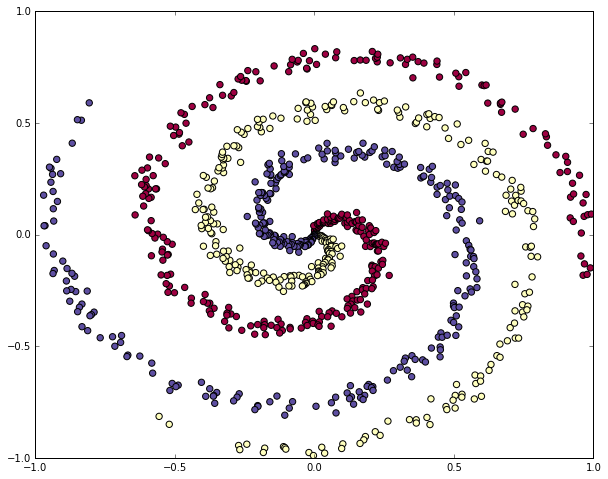

In [6]:
# Hyperparameters.
reg = 0.001        
step_size = 0.1
num_hidden = 200

data_per_class = 300  # Number of points per class
num_classes = 3       # Number of classes

X, y = generate_data(data_per_class, num_classes)
num_inputs = X.shape[1]

W1, W2 = initialize(num_inputs, num_hidden)

# Preprocess the data.
# Split data into train and test data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)
num_train = X_train.shape[0]
num_test = X_test.shape[0]

# The bias trick.
X_train = np.c_[X_train, np.ones(num_train)]
X_test = np.c_[X_test, np.ones(num_test)]

### Training steps

In [7]:
# Now we can perform gradient descent.
for i in xrange(5001):
    probs, h11, h12 = forw_prop(X_train, W1, W2)
    loss = calc_loss(probs, y_train, W1, W2, reg)
    
    dW1, dW2 = back_prop(probs, X_train, y_train, h11, h12, W1, W2, reg)
    W1 -= step_size * dW1
    W2 -= step_size * dW2
    if i % 500 == 0:
        print "Step %4d. Loss=%.3f, train accuracy=%.5f" % (i, loss, accuracy(X_train, y_train, W1, W2))
    
print "Test accuracy=%.5f" % accuracy(X_test, y_test, W1, W2)   

Step    0. Loss=2.500, train accuracy=0.33167
Step  500. Loss=1.478, train accuracy=0.61194
Step 1000. Loss=1.070, train accuracy=0.81924
Step 1500. Loss=0.951, train accuracy=0.87728
Step 2000. Loss=0.883, train accuracy=0.90381
Step 2500. Loss=0.834, train accuracy=0.91376
Step 3000. Loss=0.797, train accuracy=0.92206
Step 3500. Loss=0.768, train accuracy=0.92206
Step 4000. Loss=0.744, train accuracy=0.92371
Step 4500. Loss=0.725, train accuracy=0.92703
Step 5000. Loss=0.709, train accuracy=0.93035
Test accuracy=0.92593


### Visualization

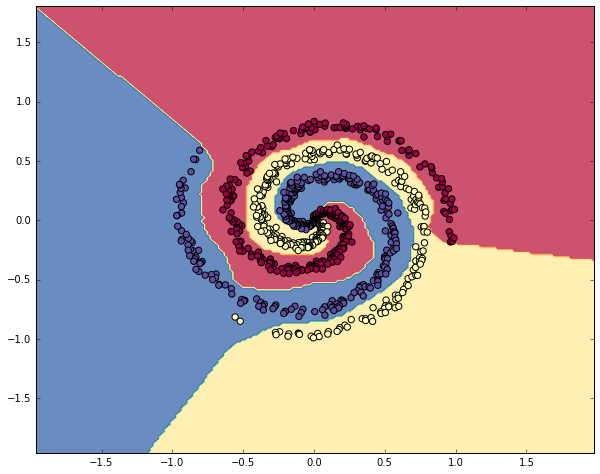

In [8]:
# Plot the resulting classifier on the test data.
h = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
h = np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], W1))
h = np.c_[h, np.ones(h.shape[0])]
Z = np.dot(h, W2)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
_=plt.ylim(yy.min(), yy.max())

### Tinkering with numpy
This part is used for tinkering with numpy to make sure operations are performed in the desired way and dimensions are preserved.


In [9]:
# Tinkering
a = np.array([[-1, 4, 5], [2, 8, 0]])
print a
print np.sum(a, axis=1)
a / a.sum(axis=1, keepdims=True).astype(float)
print np.maximum(0, a)

[[-1  4  5]
 [ 2  8  0]]
[ 8 10]
[[0 4 5]
 [2 8 0]]
